# Spline Growth Model and New Ratio Predictions (Interpolation)

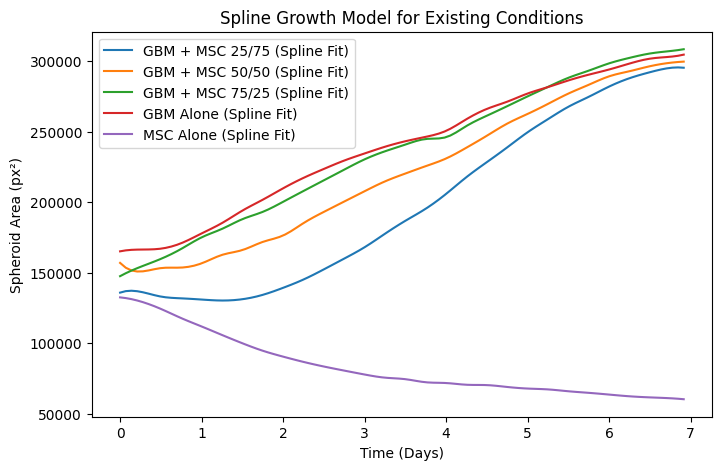

Extracted Known Ratios: [0.   0.25 0.5  0.75 1.  ]


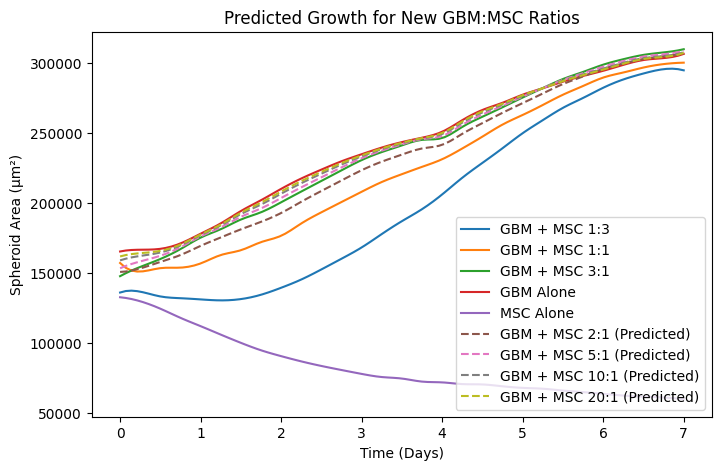

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d

# Load data
df = pd.read_csv("spheroid_comparison.csv")  # Ensure the file is in the working directory

# Ensure sorted data
df = df.dropna().sort_values(by=["Condition", "Time_Days"])

# Extract unique conditions
conditions = df["Condition"].unique()

# Store splines for each condition
interpolations = {}

plt.figure(figsize=(8, 5))

for condition in conditions:
    df_cond = df[df["Condition"] == condition]
    t_data = df_cond["Time_Days"].values
    A_data = df_cond["Mean_Area"].values

    # Fit cubic spline
    spline = CubicSpline(t_data, A_data)

    # Store interpolation for later use
    interpolations[condition] = spline

    # Generate smooth curve for visualization
    t_fit = np.linspace(min(t_data), max(t_data), 100)
    A_fit = spline(t_fit)

    plt.plot(t_fit, A_fit, label=f"{condition} (Spline Fit)")

plt.xlabel("Time (Days)")
plt.ylabel("Spheroid Area (px²)")
plt.title("Spline Growth Model for Existing Conditions")
plt.legend()
plt.grid(False)
plt.show()

# Define new GBM:MSC ratios to predict
new_ratios = [0.6, 0.9]  # Predict for GBM:MSC 60/40 and 90/10

# Extract GBM:MSC ratios correctly
known_ratios = []
ratio_to_condition = {}
label_map = {
    "GBM + MSC 91/8": "GBM + MSC 10:1",
    "GBM + MSC 75/25": "GBM + MSC 3:1",
    "GBM + MSC 50/50": "GBM + MSC 1:1",
    "GBM + MSC 25/75": "GBM + MSC 1:3",
    "GBM + MSC 67/32": "GBM + MSC 2:1",
    "GBM + MSC 83/17": "GBM + MSC 5:1",
    "GBM + MSC 95/5": "GBM + MSC 20:1",
    "GBM Alone": "GBM Alone",
    "MSC Alone": "MSC Alone"
}

for condition in conditions:
    if "GBM + MSC" in condition:
        try:
            ratio_str = condition.replace("GBM + MSC ", "")  # Remove text prefix
            gbm, msc = map(float, ratio_str.split("/"))  # Extract numbers
            ratio = gbm / (gbm + msc)  # Normalize between 0 and 1
            known_ratios.append(ratio)
            ratio_to_condition[ratio] = condition  # Store mapping
        except ValueError:
            print(f"Skipping malformed condition: {condition}")

    elif "GBM Alone" in condition:
        known_ratios.append(1.0)  # GBM Alone = 100% GBM, 0% MSC
        ratio_to_condition[1.0] = condition

    elif "MSC Alone" in condition:
        known_ratios.append(0.0)  # MSC Alone = 0% GBM, 100% MSC
        ratio_to_condition[0.0] = condition

# Convert to numpy array and sort
known_ratios = np.array(sorted(known_ratios))

# Debug: Print extracted ratios
print("Extracted Known Ratios:", known_ratios)

# Check if we found any valid ratios
if known_ratios.size == 0:
    raise ValueError("No valid GBM:MSC ratios found. Check dataset formatting.")

# Convert to numpy array and sort
known_ratios = np.array(sorted(known_ratios))


# Define function to predict growth for new GBM:MSC ratios
def predict_growth(time, gbm_msc_ratio, interpolations):
    predicted_areas = []

    for t in time:
        try:
            # Get known growth values at this time for existing ratios
            growth_values = [interpolations[ratio_to_condition[r]](t) for r in known_ratios]

            # Ensure valid growth values
            if len(growth_values) != len(known_ratios):
                print(f"Warning: Mismatch in growth values at t={t}")
                continue  # Skip if interpolation cannot be performed

            # Interpolate across different ratios
            ratio_interp = interp1d(known_ratios, growth_values, kind='linear', fill_value='extrapolate')
            predicted_areas.append(ratio_interp(gbm_msc_ratio))

        except KeyError as e:
            print(f"Error in ratio mapping: {e}")
            predicted_areas.append(np.nan)  # Avoid breaking execution

    return np.array(predicted_areas)

# Generate time range for predictions
t_range = np.linspace(0, 7, 100)

# Define new GBM:MSC ratios to predict
new_ratios = [0.67, 0.83, 0.91, 0.95]  # GBM:MSC 60/40 and 90/10

# Dictionary to store predictions
predicted_growth_curves = {}

plt.figure(figsize=(8, 5))


# Plot known data for reference
for condition, spline in interpolations.items():
    t_fit = np.linspace(0, 7, 100)
    A_fit = spline(t_fit)
    label = label_map.get(condition, condition)
    plt.plot(t_fit, A_fit, label=label)

# Predict and plot growth for new GBM:MSC ratios
for ratio in new_ratios:
    predicted_growth = predict_growth(t_range, ratio, interpolations)
    predicted_growth_curves[f"GBM:MSC {int(ratio*100)}/{int((1-ratio)*100)}"] = predicted_growth
    condition_new = f"GBM + MSC {int(ratio*100)}/{int((1-ratio)*100)}"
    label = label_map.get(condition_new, condition_new)
    plt.plot(t_range, predicted_growth, linestyle="dashed", label=f"{label} (Predicted)")

plt.xlabel("Time (Days)")
plt.ylabel("Spheroid Area (µm²)")
plt.title("Predicted Growth for New GBM:MSC Ratios")
plt.legend(loc='lower right')
plt.grid(False)
plt.show()



# Observed vs Linearly Interpolated
Interpolates intermediate GBM:MSC ratios from pure GBM and pure MSCs. 

* Visualizes them with observed counterparts
* Plots non-linear deviation of observed growth curves

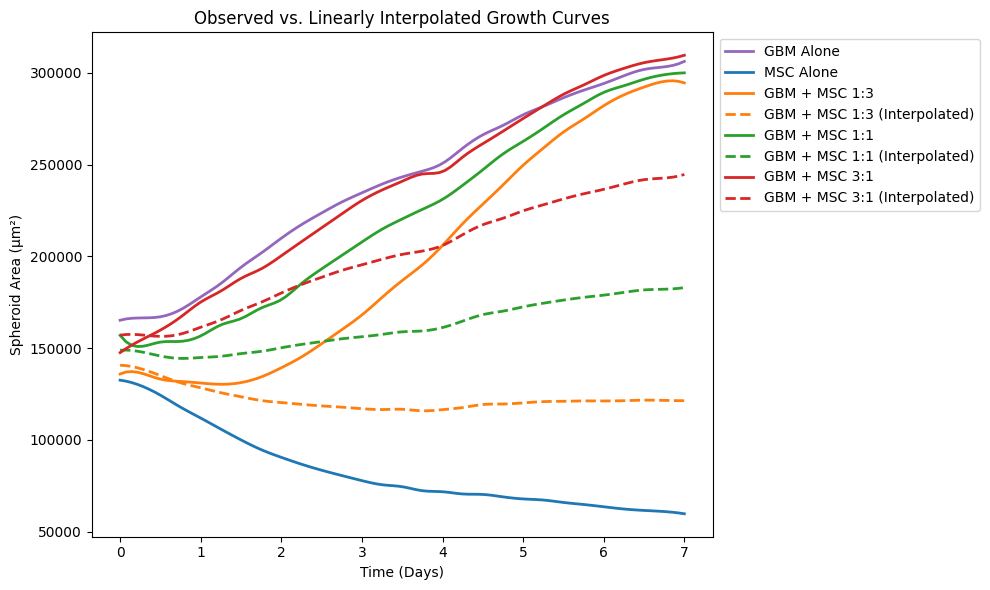

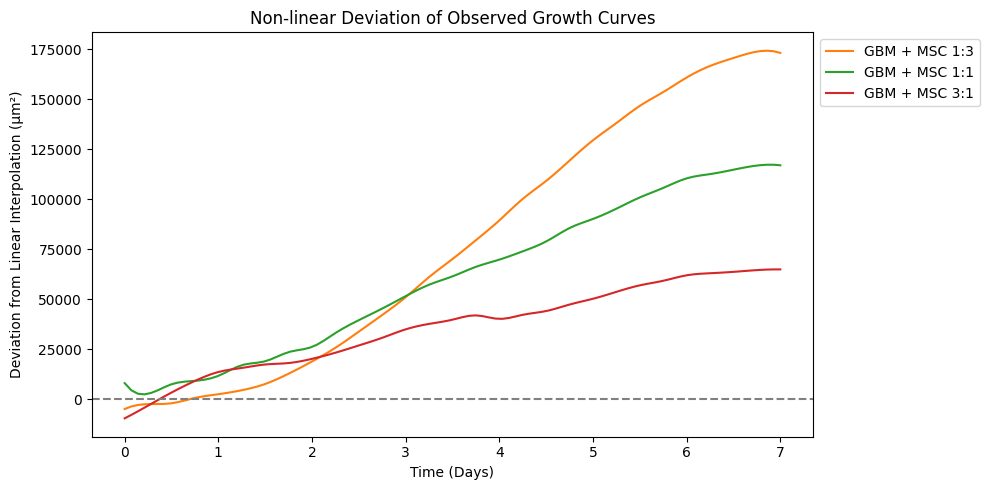

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Conversion factor: 1 px = 1.347 µm → area = 1.815 µm²
px_to_um2 = 1

# Load and preprocess
df = pd.read_csv("spheroid_comparison.csv").dropna().sort_values(by=["Condition", "Time_Days"])
conditions = df["Condition"].unique()

splines = {}
ratios = {}
pure_conditions = {}
label_map = {
    "GBM + MSC 91/9": "GBM + MSC 10:1",
    "GBM + MSC 75/25": "GBM + MSC 3:1",
    "GBM + MSC 50/50": "GBM + MSC 1:1",
    "GBM + MSC 25/75": "GBM + MSC 1:3",
    "GBM + MSC 67/33": "GBM + MSC 2:1",
    "GBM + MSC 83/17": "GBM + MSC 5:1",
    "GBM + MSC 95/5": "GBM + MSC 20:1",
    "GBM Alone": "GBM Alone",
    "MSC Alone": "MSC Alone"
}

for cond in conditions:
    df_c = df[df["Condition"] == cond]
    t = df_c["Time_Days"].values
    A = df_c["Mean_Area"].values
    spline = CubicSpline(t, A)
    splines[cond] = spline

    if "GBM Alone" in cond:
        ratios[cond] = 1.0
        pure_conditions["GBM"] = cond
    elif "MSC Alone" in cond:
        ratios[cond] = 0.0
        pure_conditions["MSC"] = cond
    elif "GBM + MSC" in cond:
        try:
            gbm, msc = map(float, cond.replace("GBM + MSC ", "").split("/"))
            ratios[cond] = gbm / (gbm + msc)
        except:
            continue

# Sort for consistent color mapping
sorted_conditions = sorted(ratios.items(), key=lambda x: x[1])
color_map = plt.get_cmap("tab10")
colors = {cond: color_map(i) for i, (cond, _) in enumerate(sorted_conditions)}

# Evaluation grid
t_eval = np.linspace(0, 7, 100)
G = splines[pure_conditions["GBM"]](t_eval) * px_to_um2
M = splines[pure_conditions["MSC"]](t_eval) * px_to_um2

# Plot actual vs interpolated
plt.figure(figsize=(10, 6))
plt.plot(t_eval, G, color=colors[pure_conditions["GBM"]], label="GBM Alone", linewidth=2)
plt.plot(t_eval, M, color=colors[pure_conditions["MSC"]], label="MSC Alone", linewidth=2)

for cond, r in ratios.items():
    if r in [0.0, 1.0]:
        continue
    actual = splines[cond](t_eval) * px_to_um2
    expected = r * G + (1 - r) * M
    color = colors[cond]
    condition_label = label_map.get(cond, cond)
    plt.plot(t_eval, actual, color=color, label=f"{condition_label}", linewidth=2)
    plt.plot(t_eval, expected, color=color, linestyle="--", label=f"{condition_label} (Interpolated)", linewidth=2)

plt.xlabel("Time (Days)")
plt.ylabel("Spheroid Area (µm²)")
plt.title("Observed vs. Linearly Interpolated Growth Curves")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot difference curves
plt.figure(figsize=(10, 5))
for cond, r in ratios.items():
    if r in [0.0, 1.0]:
        continue
    actual = splines[cond](t_eval) * px_to_um2
    expected = r * G + (1 - r) * M
    diff = actual - expected
    color = colors[cond]
    condition_label = label_map.get(cond, cond)
    plt.plot(t_eval, diff, label=f"{condition_label}", color=color)

plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Time (Days)")
plt.ylabel("Deviation from Linear Interpolation (µm²)")
plt.title("Non-linear Deviation of Observed Growth Curves")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(False)
plt.tight_layout()
plt.show()


# Quantitative Metrics: RMSE and AUC for Observed vs. Linear Interpolation

In [8]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from numpy import trapezoid  # updated from trapz

# Unit conversion: 1 px = 1.347 μm → area = 1.815 μm²
px_to_um2 = 1.347 ** 2  # = 1.815

# Load and preprocess
df = pd.read_csv("spheroid_comparison.csv").dropna().sort_values(by=["Condition", "Time_Days"])
conditions = df["Condition"].unique()

splines = {}
ratios = {}
pure_conditions = {}

for cond in conditions:
    df_c = df[df["Condition"] == cond]
    t = df_c["Time_Days"].values
    A = df_c["Mean_Area"].values
    spline = CubicSpline(t, A)
    splines[cond] = spline

    if "GBM Alone" in cond:
        ratios[cond] = 1.0
        pure_conditions["GBM"] = cond
    elif "MSC Alone" in cond:
        ratios[cond] = 0.0
        pure_conditions["MSC"] = cond
    elif "GBM + MSC" in cond:
        try:
            gbm, msc = map(float, cond.replace("GBM + MSC ", "").split("/"))
            ratios[cond] = gbm / (gbm + msc)
        except:
            continue

# Evaluation grid
t_eval = np.linspace(0, 7, 100)
G = splines[pure_conditions["GBM"]](t_eval)
M = splines[pure_conditions["MSC"]](t_eval)

# Apply unit conversion
G_um2 = G * px_to_um2
M_um2 = M * px_to_um2

# Output
print("Condition\t\tRMSE (µm²)\tRel_RMSE (%)\tAUC_Actual\tAUC_Expected\tAUC_Diff (%)")
print("-------------------------------------------------------------------------------------------")
for cond, r in ratios.items():
    if r in [0.0, 1.0]:
        continue

    actual = splines[cond](t_eval) * px_to_um2
    expected = (r * G + (1 - r) * M) * px_to_um2

    # RMSE
    rmse = np.sqrt(np.mean((actual - expected) ** 2))
    rel_rmse = 100 * rmse / np.mean(expected)

    # AUC (trapezoidal integration)
    auc_actual = trapezoid(actual, t_eval)
    auc_expected = trapezoid(expected, t_eval)
    auc_diff_pct = 100 * (auc_actual - auc_expected) / auc_expected

    print(f"{cond:20s} {rmse:10.1f} {rel_rmse:12.1f}% {auc_actual:12.1f} {auc_expected:12.1f} {auc_diff_pct:12.1f}%")


Condition		RMSE (µm²)	Rel_RMSE (%)	AUC_Actual	AUC_Expected	AUC_Diff (%)
-------------------------------------------------------------------------------------------
GBM + MSC 25/75        180264.9         81.3%    2525833.0    1550847.8         62.9%
GBM + MSC 50/50        129480.1         44.2%    2816452.0    2050437.8         37.4%
GBM + MSC 75/25         75056.7         20.6%    3006589.3    2550027.8         17.9%


# Growth Model Extrapolation: Predictive Performance on Unseen Days

This section fits classical growth models (Logistic and Gompertz) to the training portion of the data (Days 0–5) for a selected condition, then evaluates their predictive accuracy on held-out test days (Days 6–7). The results include both quantitative error metrics and a visualization comparing model predictions to observed data.

Logistic Growth Model - Mean Error on Days 6-7: 1305.62
Gompertz Growth Model - Mean Error on Days 6-7: 2943.64


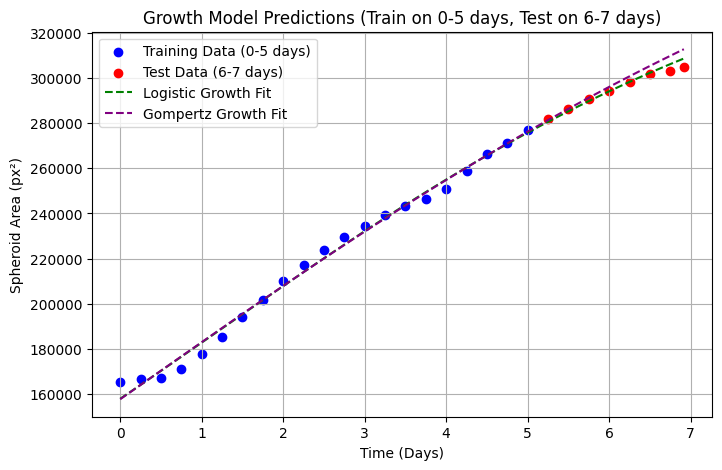

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load data
df = pd.read_csv("spheroid_comparison.csv")

# Select one condition for testing (e.g., "GBM Alone")
condition = "GBM Alone"
df_cond = df[df["Condition"] == condition]

# Extract time and area
t_data = df_cond["Time_Days"].values
A_data = df_cond["Mean_Area"].values

# Split into training (Days 0-5) and testing (Days 6-7)
train_mask = t_data <= 5
test_mask = t_data > 5

t_train, A_train = t_data[train_mask], A_data[train_mask]
t_test, A_test = t_data[test_mask], A_data[test_mask]

# Define Logistic Growth Model
def logistic_growth(t, A_max, r, t0):
    return A_max / (1 + np.exp(-r * (t - t0)))

# Define Gompertz Growth Model
def gompertz_growth(t, A_max, r, t0):
    return A_max * np.exp(-np.exp(-r * (t - t0)))

# Fit models on training data (Days 0-5)
p0 = [max(A_train), 0.3, np.median(t_train)]  # Initial guesses

# Fit Logistic model
logistic_params, _ = curve_fit(logistic_growth, t_train, A_train, p0)

# Fit Gompertz model
gompertz_params, _ = curve_fit(gompertz_growth, t_train, A_train, p0)

# Predict for full time range (including test days)
t_full = np.linspace(min(t_data), max(t_data), 100)
A_logistic_pred = logistic_growth(t_full, *logistic_params)
A_gompertz_pred = gompertz_growth(t_full, *gompertz_params)

# Predict specifically for test days (Days 6-7)
A_logistic_test = logistic_growth(t_test, *logistic_params)
A_gompertz_test = gompertz_growth(t_test, *gompertz_params)

# Compute prediction errors
logistic_error = np.abs(A_logistic_test - A_test).mean()
gompertz_error = np.abs(A_gompertz_test - A_test).mean()

print(f"Logistic Growth Model - Mean Error on Days 6-7: {logistic_error:.2f}")
print(f"Gompertz Growth Model - Mean Error on Days 6-7: {gompertz_error:.2f}")

# Plot results
plt.figure(figsize=(8, 5))

# Original data
plt.scatter(t_train, A_train, label="Training Data (0-5 days)", color="blue")
plt.scatter(t_test, A_test, label="Test Data (6-7 days)", color="red")

# Model predictions
plt.plot(t_full, A_logistic_pred, label="Logistic Growth Fit", linestyle="dashed", color="green")
plt.plot(t_full, A_gompertz_pred, label="Gompertz Growth Fit", linestyle="dashed", color="purple")

plt.xlabel("Time (Days)")
plt.ylabel("Spheroid Area (px²)")
plt.title("Growth Model Predictions (Train on 0-5 days, Test on 6-7 days)")
plt.legend()
plt.grid()
plt.show()


# Growth Rate Analysis Across Conditions

This section computes and visualizes the instantaneous growth rates (in μm²/day) for each experimental condition by differentiating the cubic spline fits of spheroid area over time. The resulting plot allows for direct comparison of how growth dynamics differ between conditions.

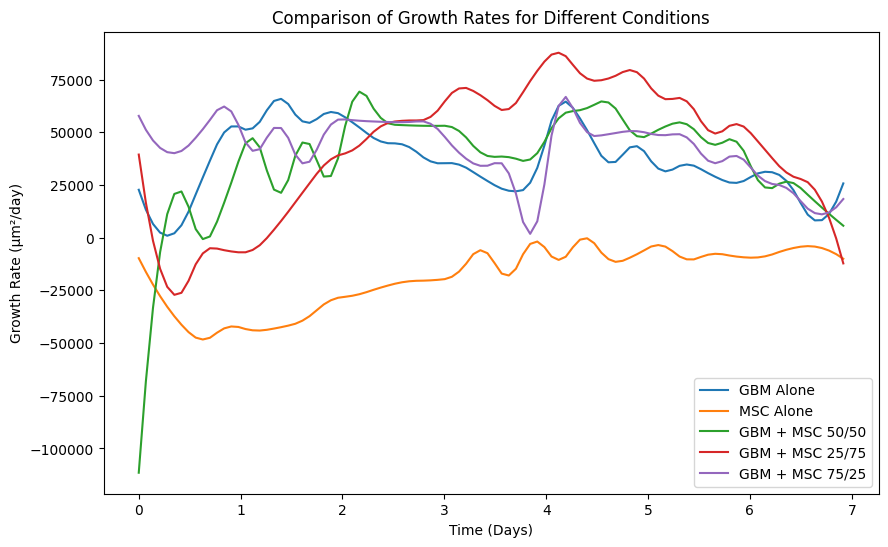

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Define Pixel-to-Real-World Conversion Factor
PIXEL_TO_UM = 1.347  # Example: 1 pixel = 1.347 μm

# Load data
df = pd.read_csv("spheroid_comparison.csv")

# Get unique conditions
conditions = df["Condition"].unique()

# Create plot
plt.figure(figsize=(10, 6))

# Loop through each condition and compute growth rate
for condition in conditions:
    df_cond = df[df["Condition"] == condition]
    
    # Extract time and area
    t_data = df_cond["Time_Days"].values
    A_data = df_cond["Mean_Area"].values

    # Fit cubic spline
    spline = CubicSpline(t_data, A_data)

    # Compute growth rate (derivative of the spline)
    t_fine = np.linspace(min(t_data), max(t_data), 100)
    growth_rate_px = spline.derivative()(t_fine)  # Growth rate in pixels²/day

    # Convert growth rate to μm²/day
    growth_rate_um = growth_rate_px * (PIXEL_TO_UM ** 2)  # Convert px²/day to μm²/day

    # Plot Growth Rate
    plt.plot(t_fine, growth_rate_um, label=condition)

# Customize plot
plt.xlabel("Time (Days)")
plt.ylabel("Growth Rate (μm²/day)")
plt.title("Comparison of Growth Rates for Different Conditions")
plt.legend()
plt.grid(False)

# Show plot
plt.show()
